In [1]:
options(warn = -1, verbose=FALSE)
#!/usr/bin/env Rscript 
library(dplyr)
library(httr)
library(cowplot)
library(unixtools)
library(repr)
library(tidygraph)
library(ggraph)
library(geojsonio)
library(ggdark)
library(ggmin)
set_config(config(ssl_verifypeer = 0L))
ulimit::memory_limit(100000)
set.tempdir("/datastore/lucy/tmp/")
setwd("/datastore/lucy/CosMx")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidygraph’


The following object is masked from ‘package:stats’:

    filter


Loading required package: ggplot2

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


Attaching package: ‘geojsonio’


The following object is masked from ‘package:base’:

    pretty




soft  hard 
1e+05   Inf

In [2]:
source("./R/utils.R")
start_upR(TRUE)
source("./R/TissueSegFunctions.R")
library(Matrix)

In [3]:
#Load transcript files
fov_tfiles_list<-list.files(
    "/datastore/lucy/CosMx/nanostring_raw/FOV_tx/", 
    pattern = "tx.csv", 
    recursive = TRUE,
    full.names = TRUE
)

In [4]:
tail(fov_tfiles_list)

[1] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F014_tx.csv"
[2] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F015_tx.csv"
[3] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F017_tx.csv"
[4] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F018_tx.csv"
[5] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F019_tx.csv"
[6] "/datastore/lucy/CosMx/nanostring_raw/FOV_tx//RemissionRA_Run5666_G2697_G1532_F020_tx.csv"

In [19]:
fov.interest <- c("Active RA_Run5666_G7G72_G22G5_F023")

In [20]:
#Load transcripts
tx<-fread(paste0("/datastore/lucy/CosMx/nanostring_raw/FOV_tx//",fov.interest,"_tx.csv"))[, .(x, y, z, gene, cell, SampleID, SampleFOV)
        ][, `:=` (pxsize = 0.168)
        ][, `:=` (x = x * pxsize, y = y * pxsize)
        ] %>% 
        sf::st_as_sf(coords = c("x", "y"), remove = FALSE) 
tx$cellID <- tx$cell
head(tx)

x        y         z gene   cell                          
1 44856.18 -6072.076 0 COL3A1 C5699_Run5666_G7G72_G22G5_F023
2 44785.62 -6072.209 0 DUSP1  C5358_Run5666_G7G72_G22G5_F023
3 44785.17 -6072.378 0 TNFSF4 C5358_Run5666_G7G72_G22G5_F023
4 44850.84 -6072.474 0 CHGA   C7426_Run5666_G7G72_G22G5_F023
5 44853.53 -6073.084 0 HLA-B  C5699_Run5666_G7G72_G22G5_F023
6 44755.44 -6073.217 0 C1QC   C5233_Run5666_G7G72_G22G5_F023
  SampleID            SampleFOV                          pxsize
1 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
2 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
3 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
4 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
5 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
6 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
  geometry                   cellID                        
1 POINT (44856.18 -6072.076) C5699_Run5666_G7G72_G22G5_F023
2 POINT (44785.62 -6072.209) C5358_Run5666_G7G72_G22G5_F023
3 POINT (44785.17 -6072.378) C5358_Run5666_G7G72_G22G5_F023
4 POINT (44850.84 -6072.474) C7426_Run5666_G7G72_G22G5_F023
5 POINT (44853.53 -6073.084) C5699_Run5666_G7G72_G22G5_F023
6 POINT (44755.44 -6073.217) C5233_Run5666_G7G72_G22G5_F023

In [21]:
#Load cell geometries
cellgeoms<-readRDS("./cache/raw/Glasgow_cellgeoms_QC.RDS") %>% st_sf() %>% rename(cell_center_x = center_x, cell_center_y = center_y, cell_centroid=centroid) %>%
    dplyr::mutate(cell_centroid = st_centroid(shape), pxsize = 0.168) %>% unite("SampleFOV",c(SampleID, FOV), remove=FALSE) %>% dplyr::mutate(cell_center_x=cell_center_x*pxsize,
                                                                                                                                              cell_center_y=cell_center_y*pxsize,
                                                                                                                                              geometry=shape*pxsize,
                                                                                                                                              cell_centroid=cell_centroid*pxsize)

In [22]:
sampleFOVcondition <- read.table("/datastore/lucy/CosMx/cache/SampleFOV-condition.csv", header=TRUE, sep=",")
cellgeoms <- merge(cellgeoms, sampleFOVcondition, all=FALSE)
cellgeoms$SampleFOV <- paste0(cellgeoms$Condition,"_",cellgeoms$SampleFOV)
head(cellgeoms)

SampleFOV                          SampleID            FOV 
1 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
2 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
3 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
4 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
5 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
6 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
  cellID                       cell area_um  radius_um cell_center_x
1 C18_Run5654_399G0_32G77_F001 18   20.97153 2.583688  23171.10     
2 C26_Run5654_399G0_32G77_F001 26   42.90907 3.695725  23342.02     
3 C27_Run5654_399G0_32G77_F001 27   17.77128 2.378397  23361.90     
4 C28_Run5654_399G0_32G77_F001 28   32.12423 3.197727  23353.14     
5 C29_Run5654_399G0_32G77_F001 29   15.89895 2.249621  23232.99     
6 C32_Run5654_399G0_32G77_F001 32   47.80699 3.900953  23372.56     
  cell_center_y pxsize PatientID Condition shape                     
1 -1512.382     0.168  32G77     Active RA POINT (23171.1 -1512.382) 
2 -1654.621     0.168  32G77     Active RA POINT (23342.02 -1654.621)
3 -1671.197     0.168  32G77     Active RA POINT (23361.9 -1671.197) 
4 -1664.544     0.168  32G77     Active RA POINT (23353.14 -1664.544)
5 -1540.613     0.168  32G77     Active RA POINT (23232.99 -1540.613)
6 -1680.999     0.168  32G77     Active RA POINT (23372.56 -1680.999)
  geometry                      
1 MULTIPOLYGON (((23172.2 -15...
2 MULTIPOLYGON (((23343.97 -1...
3 MULTIPOLYGON (((23362.4 -16...
4 MULTIPOLYGON (((23354.82 -1...
5 MULTIPOLYGON (((23233.77 -1...
6 MULTIPOLYGON (((23370.71 -1...

In [23]:
#Load cell annotations
cell_ann<-readRDS("cache/CosMxcoarseGrainharmonyObj_markers.RDS")$metadata
cell_ann <- cell_ann %>% dplyr::select(cellID, new.coarse.types, fine.types)

In [45]:
#Merge transcripts info with cell annotations
tx <- tx %>% left_join(cell_ann, by = "cellID")
head(tx)

x        y         z gene   cell                          
1 44856.18 -6072.076 0 COL3A1 C5699_Run5666_G7G72_G22G5_F023
2 44785.62 -6072.209 0 DUSP1  C5358_Run5666_G7G72_G22G5_F023
3 44785.17 -6072.378 0 TNFSF4 C5358_Run5666_G7G72_G22G5_F023
4 44850.84 -6072.474 0 CHGA   C7426_Run5666_G7G72_G22G5_F023
5 44853.53 -6073.084 0 HLA-B  C5699_Run5666_G7G72_G22G5_F023
6 44755.44 -6073.217 0 C1QC   C5233_Run5666_G7G72_G22G5_F023
  SampleID            SampleFOV                          pxsize
1 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
2 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
3 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
4 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
5 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
6 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
  cellID                         new.coarse.types fine.types              
1 C5699_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
2 C5358_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
3 C5358_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
4 C7426_Run5666_G7G72_G22G5_F023 NA               NA                      
5 C5699_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
6 C5233_Run5666_G7G72_G22G5_F023 Macrophage       Myeloid_DC3/FLS doublet 
  geometry                  
1 POINT (44856.18 -6072.076)
2 POINT (44785.62 -6072.209)
3 POINT (44785.17 -6072.378)
4 POINT (44850.84 -6072.474)
5 POINT (44853.53 -6073.084)
6 POINT (44755.44 -6073.217)

In [24]:
#Merge geometeries info with cell annotations
cellgeoms <- cellgeoms %>% left_join(cell_ann, by = "cellID")
head(cellgeoms)

SampleFOV                          SampleID            FOV 
1 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
2 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
3 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
4 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
5 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
6 Active RA_Run5654_399G0_32G77_F001 Run5654_399G0_32G77 F001
  cellID                       cell area_um  radius_um cell_center_x
1 C18_Run5654_399G0_32G77_F001 18   20.97153 2.583688  23171.10     
2 C26_Run5654_399G0_32G77_F001 26   42.90907 3.695725  23342.02     
3 C27_Run5654_399G0_32G77_F001 27   17.77128 2.378397  23361.90     
4 C28_Run5654_399G0_32G77_F001 28   32.12423 3.197727  23353.14     
5 C29_Run5654_399G0_32G77_F001 29   15.89895 2.249621  23232.99     
6 C32_Run5654_399G0_32G77_F001 32   47.80699 3.900953  23372.56     
  cell_center_y pxsize PatientID Condition new.coarse.types       
1 -1512.382     0.168  32G77     Active RA Fibroblast             
2 -1654.621     0.168  32G77     Active RA Macrophage             
3 -1671.197     0.168  32G77     Active RA Macrophage             
4 -1664.544     0.168  32G77     Active RA cDC                    
5 -1540.613     0.168  32G77     Active RA NA                     
6 -1680.999     0.168  32G77     Active RA PRG4+ Lining Fibroblast
  fine.types                  shape                     
1 Stromal_THY1+COL1A1+ FLS    POINT (23171.1 -1512.382) 
2 Myeloid_FOLR2highLYVE1+ STM POINT (23342.02 -1654.621)
3 Myeloid_SPP1+TREM2low STM   POINT (23361.9 -1671.197) 
4 Myeloid_iDC3 CD14highCD163+ POINT (23353.14 -1664.544)
5 NA                          POINT (23232.99 -1540.613)
6 Stromal_PRG4+ lining FLS    POINT (23372.56 -1680.999)
  geometry                      
1 MULTIPOLYGON (((23172.2 -15...
2 MULTIPOLYGON (((23343.97 -1...
3 MULTIPOLYGON (((23362.4 -16...
4 MULTIPOLYGON (((23354.82 -1...
5 MULTIPOLYGON (((23233.77 -1...
6 MULTIPOLYGON (((23370.71 -1...

In [25]:
cells<-cellgeoms %>% subset(SampleFOV %in% fov.interest)
head(cells)

SampleFOV                          SampleID            FOV 
151654 Active RA_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5 F023
151655 Active RA_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5 F023
151656 Active RA_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5 F023
151657 Active RA_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5 F023
151658 Active RA_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5 F023
151659 Active RA_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5 F023
       cellID                       cell area_um  radius_um cell_center_x
151654 C1_Run5666_G7G72_G22G5_F023  1    20.57833 2.559352  44438.43     
151655 C4_Run5666_G7G72_G22G5_F023  4    30.98305 3.140416  44449.67     
151656 C7_Run5666_G7G72_G22G5_F023  7    63.58398 4.498823  44440.70     
151657 C15_Run5666_G7G72_G22G5_F023 15   19.09967 2.465687  44482.04     
151658 C19_Run5666_G7G72_G22G5_F023 19   63.75168 4.504752  44497.44     
151659 C21_Run5666_G7G72_G22G5_F023 21   55.15838 4.190162  44478.50     
       cell_center_y pxsize PatientID Condition new.coarse.types
151654 -6807.852     0.168  G7G72     Active RA Macrophage      
151655 -6797.188     0.168  G7G72     Active RA Fibroblast      
151656 -6779.110     0.168  G7G72     Active RA Macrophage      
151657 -6802.924     0.168  G7G72     Active RA Fibroblast      
151658 -6814.590     0.168  G7G72     Active RA Endothelial     
151659 -6791.676     0.168  G7G72     Active RA CD4+ Tcell      
       fine.types                    shape                     
151654 Myeloid_FOLR2highLYVE1+ STM   POINT (44438.43 -6807.852)
151655 Stromal_C1QA+ FLS doublets    POINT (44449.67 -6797.188)
151656 Myeloid_FOLR2highCLEC10A+ STM POINT (44440.7 -6779.11)  
151657 Stromal_THY1+COL1A1+ FLS      POINT (44482.04 -6802.924)
151658 Stromal_SPARC+ capillary EC   POINT (44497.44 -6814.59) 
151659 Tcell_CCL5+GZMA+CD4+ TEM      POINT (44478.5 -6791.676) 
       geometry                      
151654 MULTIPOLYGON (((44440.88 -6...
151655 MULTIPOLYGON (((44449.48 -6...
151656 MULTIPOLYGON (((44438.55 -6...
151657 MULTIPOLYGON (((44482.45 -6...
151658 MULTIPOLYGON (((44495.29 -6...
151659 MULTIPOLYGON (((44479.6 -67...

In [72]:
cols <- c("#ffeca9","gold","sienna1","sienna3","red3","pink","deeppink","green3","green4","darkgreen","lightblue1","royalblue1","turquoise1")
names(cols) <- levels(cellgeoms$new.coarse.types)

In [73]:
head(tx)

x        y         z gene   cell                          
1 44856.18 -6072.076 0 COL3A1 C5699_Run5666_G7G72_G22G5_F023
2 44785.62 -6072.209 0 DUSP1  C5358_Run5666_G7G72_G22G5_F023
3 44785.17 -6072.378 0 TNFSF4 C5358_Run5666_G7G72_G22G5_F023
4 44850.84 -6072.474 0 CHGA   C7426_Run5666_G7G72_G22G5_F023
5 44853.53 -6073.084 0 HLA-B  C5699_Run5666_G7G72_G22G5_F023
6 44755.44 -6073.217 0 C1QC   C5233_Run5666_G7G72_G22G5_F023
  SampleID            SampleFOV                          pxsize
1 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
2 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
3 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
4 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
5 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
6 Run5666_G7G72_G22G5 Active RA_Run5666_G7G72_G22G5_F023 0.168 
  cellID                         new.coarse.types fine.types              
1 C5699_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
2 C5358_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
3 C5358_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
4 C7426_Run5666_G7G72_G22G5_F023 NA               NA                      
5 C5699_Run5666_G7G72_G22G5_F023 Fibroblast       Stromal_THY1+COL1A1+ FLS
6 C5233_Run5666_G7G72_G22G5_F023 Macrophage       Myeloid_DC3/FLS doublet 
  geometry                  
1 POINT (44856.18 -6072.076)
2 POINT (44785.62 -6072.209)
3 POINT (44785.17 -6072.378)
4 POINT (44850.84 -6072.474)
5 POINT (44853.53 -6073.084)
6 POINT (44755.44 -6073.217)

## Plot localization of coarse cell types

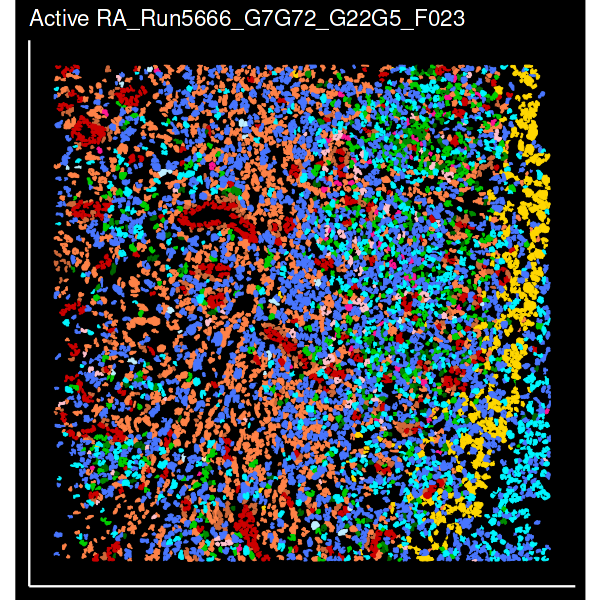

In [75]:
#Visualize full FOV
library(ggdark)
options(repr.plot.width=5, repr.plot.height=5)
cells %>% 
        ggplot() + 
            geom_sf(aes(geometry = geometry, fill = new.coarse.types, color=new.coarse.types), na.rm=TRUE) + #geom_sf(data = niche_shape) +
            scale_fill_manual(values = cols, na.value = "black", na.translate = TRUE) + scale_color_manual(values = cols,na.value="black")+ dark_theme_classic() +
            ggtitle(cells$SampleFOV) + guides(fill=FALSE, color=FALSE) + theme(axis.text=element_blank(), axis.ticks=element_blank()) 
    

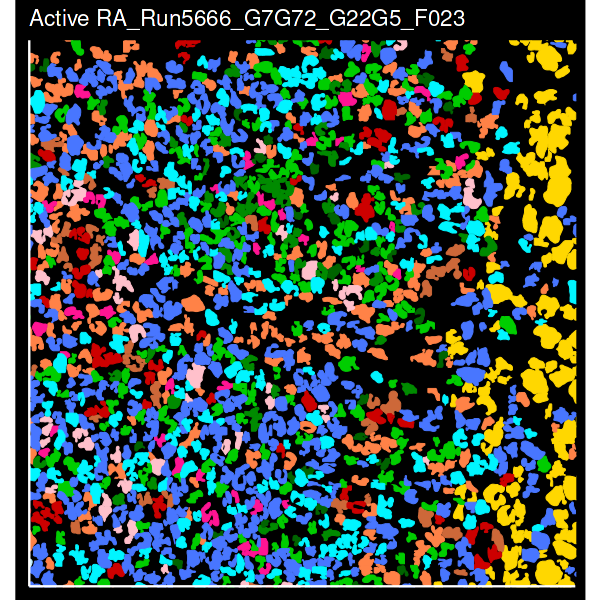

In [76]:
#Reduce area to region of interest
options(repr.plot.width=5, repr.plot.height=5)
cells %>% 
        ggplot() + 
            geom_sf(aes(geometry = geometry, fill = new.coarse.types, color=new.coarse.types), na.rm=TRUE) + #geom_sf(data = niche_shape) +
            scale_fill_manual(values = cols, na.value = "black", na.translate = TRUE) + scale_color_manual(values = cols,na.value="black")+ dark_theme_classic() +
            ggtitle(cells$SampleFOV) + guides(fill=FALSE, color=FALSE) + theme(axis.text=element_blank(), axis.ticks=element_blank()) + coord_sf(ylim = c(-6100,-6400), xlim=c(44850,45150), clip = "on")
    

## Plot localization of cell types of interest

In [27]:
cells$interest <- ifelse(cells$fine.types%in%c(
                                 'Myeloid_iDC3 CD14highCD163+',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH'), as.character(cells$fine.types), NA)
cells$interest <- as.ordered(factor(cells$interest, levels=c('Myeloid_iDC3 CD14highCD163+',
                                  'Tcell_CCL5+GZMA+CD4+ TEM',
                                 'Tcell_CCL5+CXCR6+MAF+ TPH')))

In [28]:
cols <- c("white","#FF3131","dodgerblue2",rep("black",13))
names(cols) <- levels(cells$interest)
outline.cols <- c("white","#FF3131","dodgerblue2",rep("grey50",14),rep("black",13))
names(outline.cols) <- levels(cells$interest)

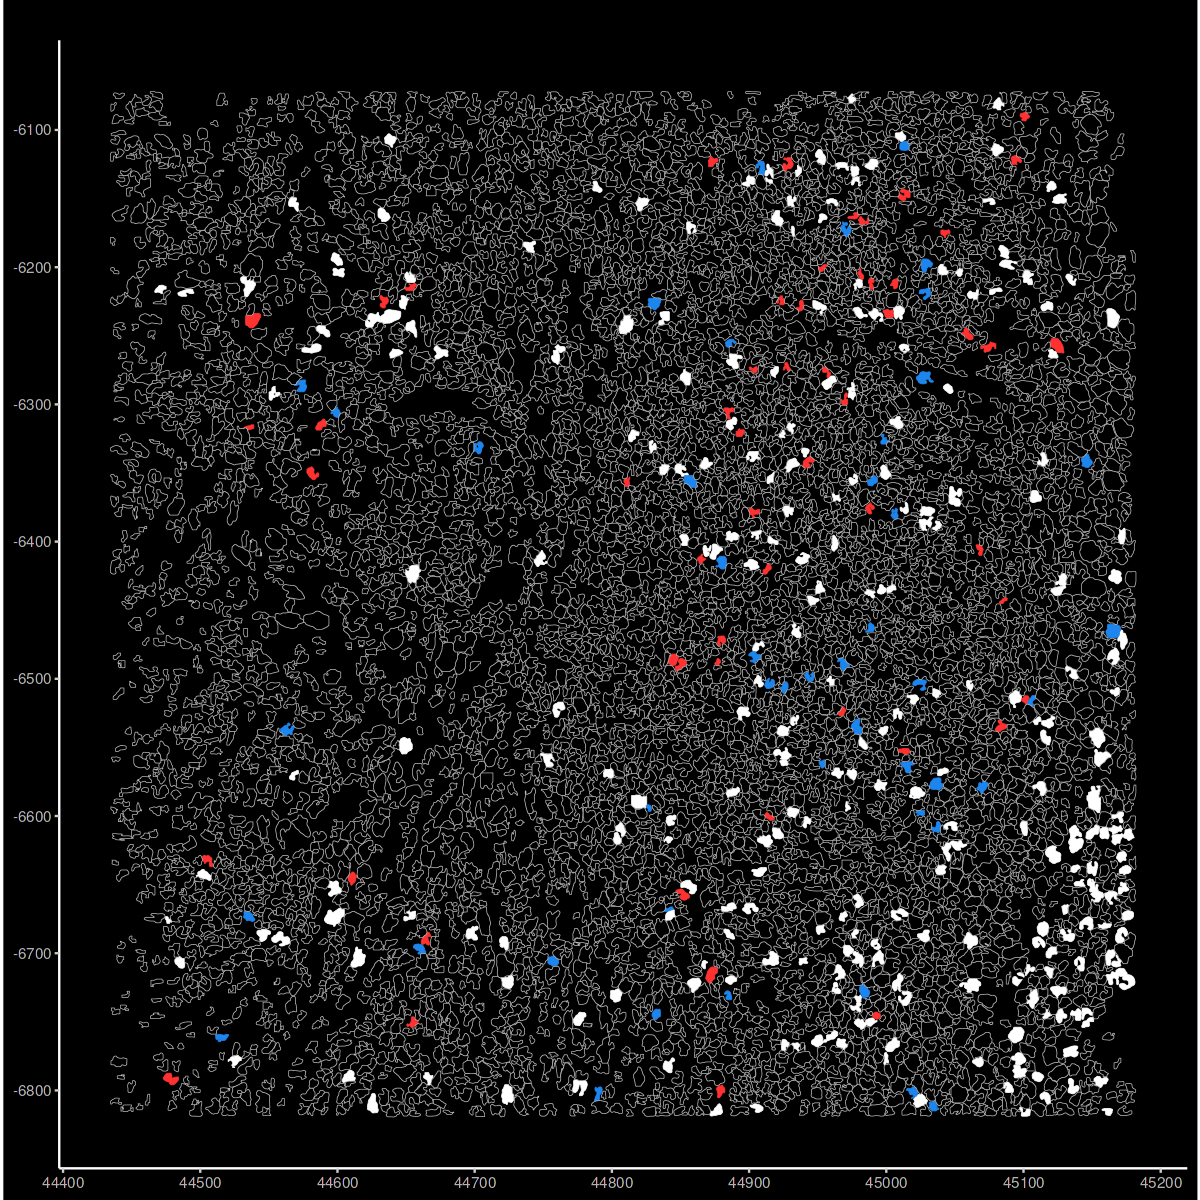

In [29]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot() + geom_sf(data = cells, aes(geometry = geometry, fill = interest, color=interest), na.rm=TRUE,linewidth = 0.15) + 
     scale_fill_manual(values = cols, na.value = "black", na.translate = TRUE) + scale_color_manual(values = outline.cols,na.value="grey")+ ggtitle(cellgeoms$SampleFOV)+ theme_powerpoint() + ggtitle("")+ theme_powerpoint() + dark_theme_classic() + guides(fill=FALSE, color=FALSE) 

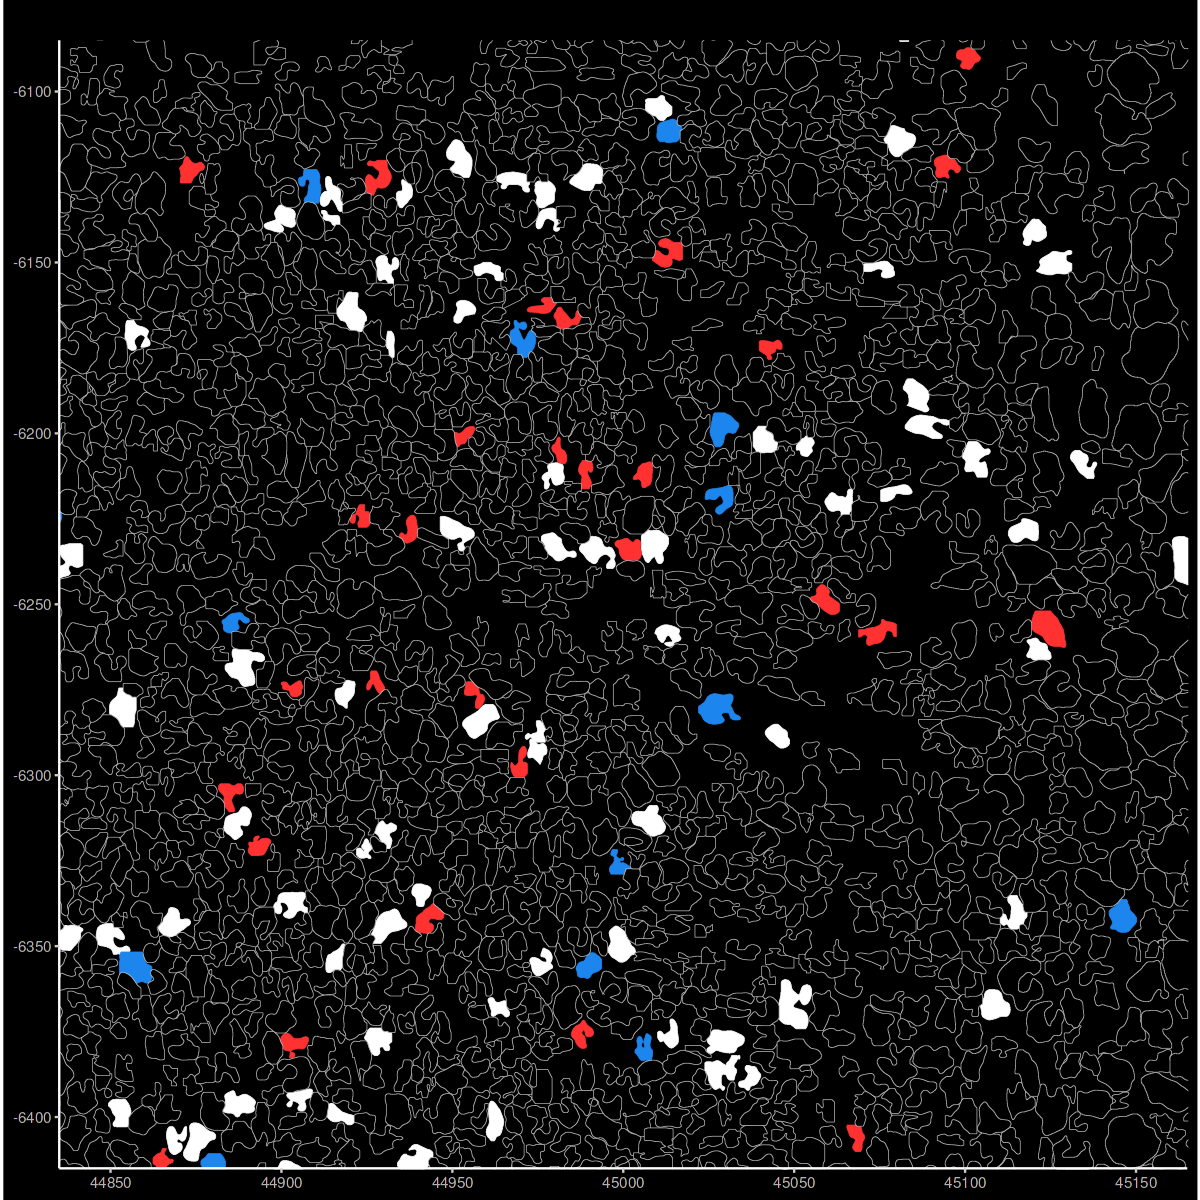

In [30]:
options(repr.plot.width=10, repr.plot.height=10)
ggplot() + geom_sf(data = cells, aes(geometry = geometry, fill = interest, color=interest), na.rm=TRUE,linewidth = 0.15) + 
     scale_fill_manual(values = cols, na.value = "black", na.translate = TRUE) + scale_color_manual(values = outline.cols,na.value="grey")+ ggtitle(cellgeoms$SampleFOV)+ theme_powerpoint() + ggtitle("")+ theme_powerpoint() + dark_theme_classic() + guides(fill=FALSE, color=FALSE)  + coord_sf(ylim = c(-6100,-6400), xlim=c(44850,45150), clip = "on")

## Plot transcript localization on cells of interest

In [78]:
cd4.cols <- c("black","black","black","black","black","black","black","green3","black","black","black","black","black")
names(cd4.cols) <- levels(cellgeoms$new.coarse.types)

In [79]:
cd4.outline.cols <- c("darkgrey","darkgrey","darkgrey","darkgrey","darkgrey","darkgrey","darkgrey","green3","darkgrey","darkgrey","darkgrey","darkgrey","darkgrey")
names(cd4.outline.cols) <- levels(cellgeoms$new.coarse.types)

In [80]:
ccl5.pos <- tx[which(tx$gene%in%c("CCL5")&tx$new.coarse.types%in%c("CD4+ Tcell")),]

In [55]:
head(ccl5.pos)

x        y         z gene cell                           SampleID           
1 44811.50 -6355.978 1 CCL5 C7844_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5
2 45006.68 -6520.041 1 CCL5 C8864_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5
3 44810.66 -6355.850 1 CCL5 C7844_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5
4 44810.24 -6356.750 1 CCL5 C7844_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5
5 44633.43 -6229.114 3 CCL5 C3274_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5
6 45099.82 -6516.085 5 CCL5 C4616_Run5666_G7G72_G22G5_F023 Run5666_G7G72_G22G5
  SampleFOV                          pxsize cellID                        
1 Active RA_Run5666_G7G72_G22G5_F023 0.168  C7844_Run5666_G7G72_G22G5_F023
2 Active RA_Run5666_G7G72_G22G5_F023 0.168  C8864_Run5666_G7G72_G22G5_F023
3 Active RA_Run5666_G7G72_G22G5_F023 0.168  C7844_Run5666_G7G72_G22G5_F023
4 Active RA_Run5666_G7G72_G22G5_F023 0.168  C7844_Run5666_G7G72_G22G5_F023
5 Active RA_Run5666_G7G72_G22G5_F023 0.168  C3274_Run5666_G7G72_G22G5_F023
6 Active RA_Run5666_G7G72_G22G5_F023 0.168  C4616_Run5666_G7G72_G22G5_F023
  new.coarse.types fine.types               geometry                  
1 CD4+ Tcell       Tcell_CCL5+GZMA+CD4+ TEM POINT (44811.5 -6355.978) 
2 CD4+ Tcell       Tcell_T/C1QA doublet     POINT (45006.68 -6520.041)
3 CD4+ Tcell       Tcell_CCL5+GZMA+CD4+ TEM POINT (44810.66 -6355.85) 
4 CD4+ Tcell       Tcell_CCL5+GZMA+CD4+ TEM POINT (44810.24 -6356.75) 
5 CD4+ Tcell       Tcell_CCL5+GZMA+CD4+ TEM POINT (44633.43 -6229.114)
6 CD4+ Tcell       Tcell_CCL5+GZMA+CD4+ TEM POINT (45099.82 -6516.085)

In [56]:
cells$ccl5.pos <- ifelse(cells$cellID%in%ccl5.pos$cellID, as.character(cells$new.coarse.types), NA)

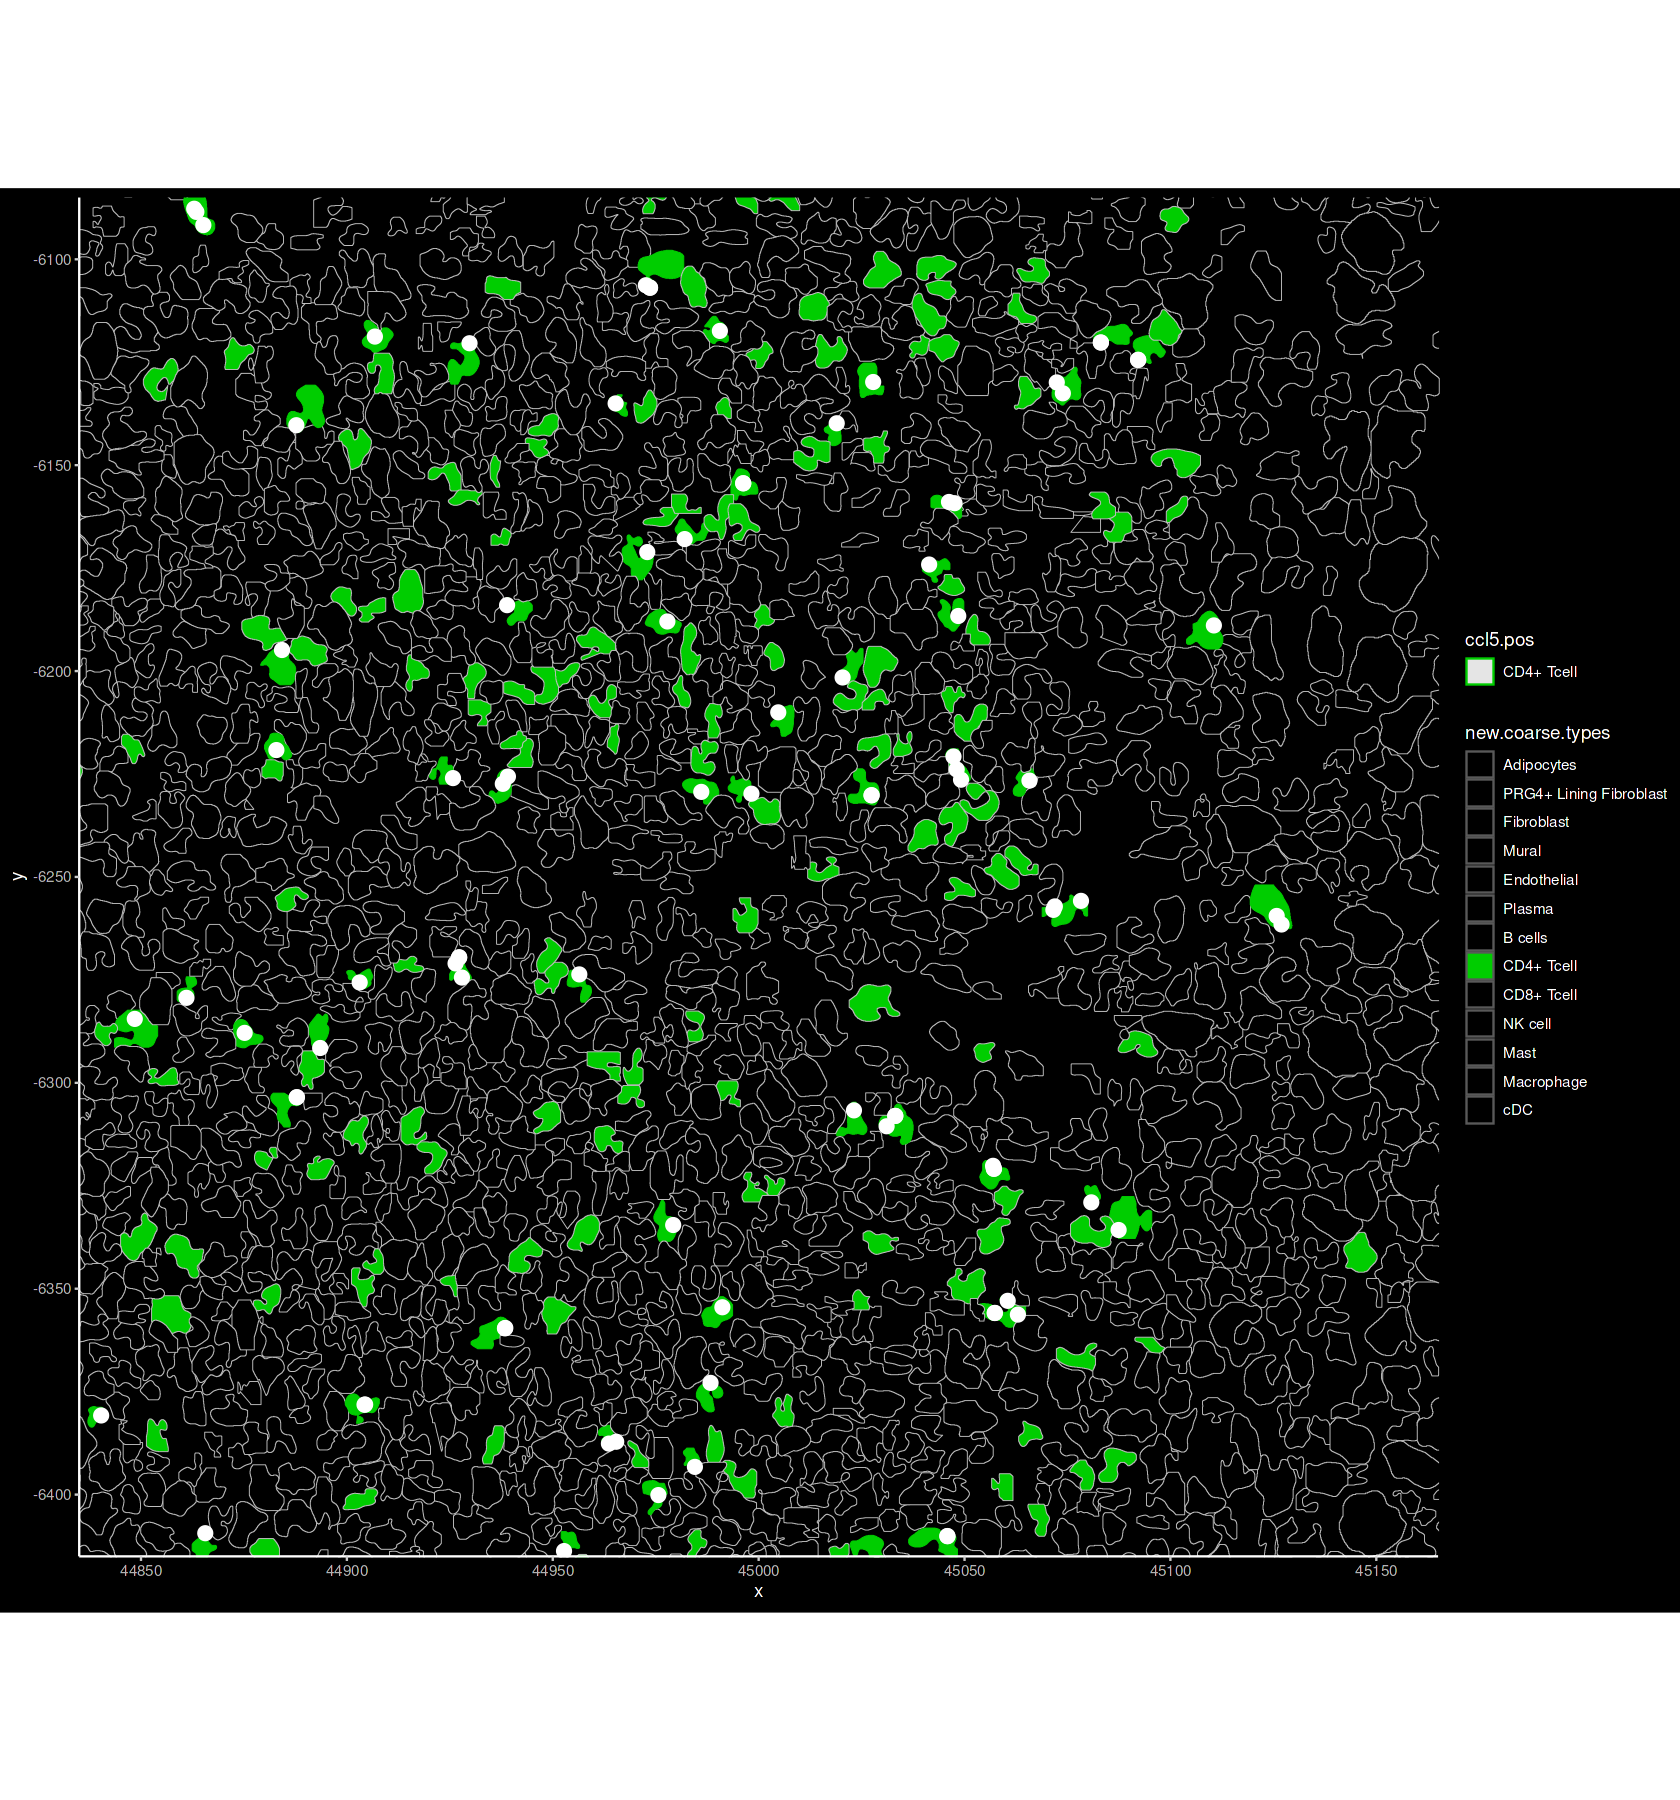

In [67]:
library(ggdark)
options(repr.plot.width=14, repr.plot.height=15)
ggplot() +
geom_sf(data = cells, aes(geometry=geometry,fill=ccl5.pos,color=ccl5.pos), na.value="black", size=3) +
geom_point(data = ccl5.pos, aes(x=x,y=y,colour=gene), color="white",size=3.5) + scale_fill_manual(values=cd4.cols, na.value="black") +scale_color_manual(values=cd4.outline.cols, na.value="grey") + dark_theme_classic()  + coord_sf(ylim = c(-6100,-6400), xlim=c(44850,45150), clip = "on")
#+ scale_fill_manual(values=cols) + 